## Introduction

This dataset contains histopathological images of oral cavity tissue, categorized into normal epithelium and Oral Squamous Cell Carcinoma (OSCC).
Originally, it includes 1,224 images captured using a Leica ICC50 HD microscope from H&E stained tissue slides, prepared and annotated by medical experts from 230 patients.
The dataset is divided into two sets based on magnification: the first set includes 89 normal and 439 OSCC images at 100x magnification, while the second set includes 201 normal and 495 OSCC images at 400x magnification.
After applying data augmentation techniques, the dataset was expanded to include 2,435 normal and 2,511 OSCC images.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.layers import LayerNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.losses import CategoricalCrossentropy

In [3]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.get_logger().setLevel('ERROR')


## Data Loading and Preprocessing

In [4]:
normal_path = 'OralCancer/Normal'
oscc_path = 'OralCancer/OSCC'

In [5]:
def load_images(folder_path, label, image_size=(128, 128)):
    images = []
    labels = []
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)


# Load Normal and OSCC images
normal_images, normal_labels = load_images(normal_path, label=0)
oscc_images, oscc_labels = load_images(oscc_path, label=1)

# Now merge them
images = np.concatenate((normal_images, oscc_images), axis=0)
labels = np.concatenate((normal_labels, oscc_labels), axis=0)


In [6]:
print(f"Total images loaded: {len(images)}")

Total images loaded: 4946


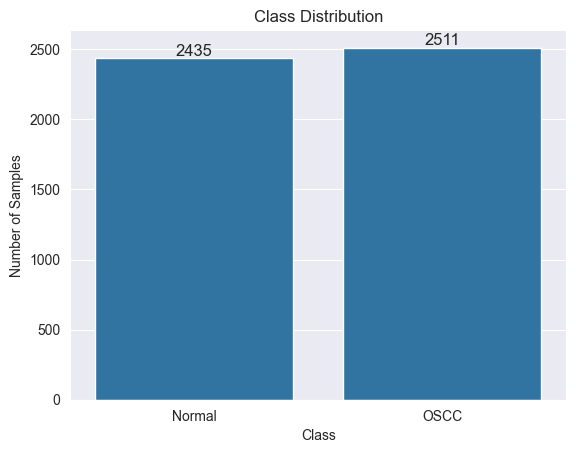

In [7]:
label_counts = np.unique(labels, return_counts=True)
class_names = ['Normal', 'OSCC']

ax = sns.barplot(x=class_names, y=label_counts[1])
for i, count in enumerate(label_counts[1]):
    ax.text(i, count + 0.05, str(count), ha='center', va='bottom', fontsize=12)
plt.title("Class Distribution")
plt.ylabel("Number of Samples")
plt.xlabel("Class")
plt.show()

In [8]:
# Normalize images
images = images / 255.0
# # One-hot encode labels
# labels = to_categorical(labels, num_classes=2)

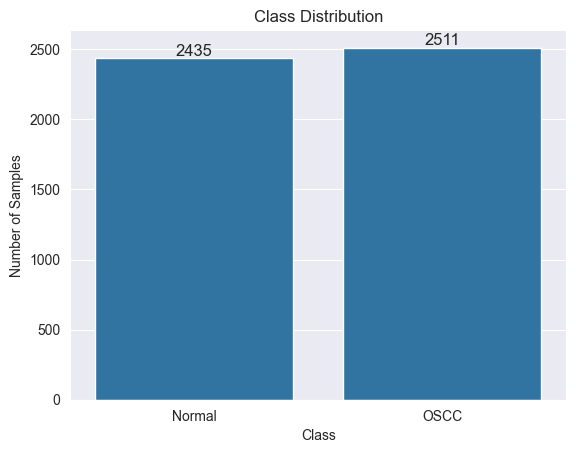

In [9]:
label_counts = np.unique(labels, return_counts=True)
class_names = ['Normal', 'OSCC']

ax = sns.barplot(x=class_names, y=label_counts[1])
for i, count in enumerate(label_counts[1]):
    ax.text(i, count + 0.05, str(count), ha='center', va='bottom', fontsize=12)
plt.title("Class Distribution")
plt.ylabel("Number of Samples")
plt.xlabel("Class")
plt.show()

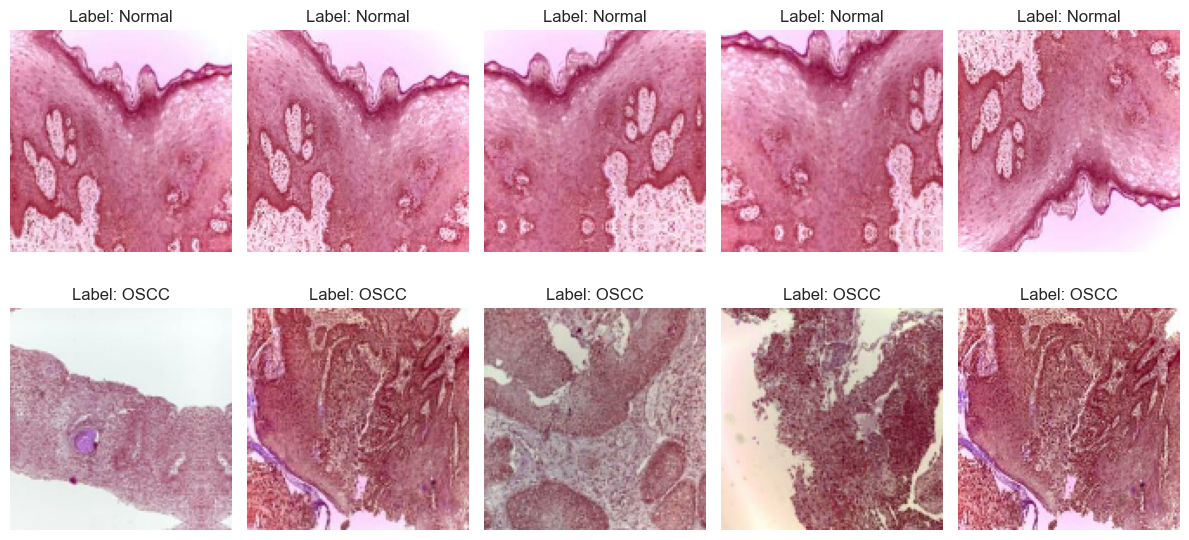

In [10]:
plt.figure(figsize=(12, 6))

class_names = {0: "Normal", 1: "OSCC"}

# Get indices for each class
for class_label in [0, 1]:
    indices = np.where(labels == class_label)[0]

    for i in range(5):
        plt.subplot(2, 5, i + 1 + (5 * class_label))
        plt.imshow(images[indices[i]])
        plt.title(f"Label: {class_names[class_label]}")
        plt.axis("off")

plt.tight_layout()
plt.show()


In [11]:
# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=97, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=97, stratify=y_temp)

## Model Architecture

In [64]:
model = Sequential([
    # Convolutional Block 1
    Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(rate= 0.3, seed= 123),

    # Convolutional Block 2
    Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(rate= 0.3, seed= 123),

    # MaxPooling (Final Pooling Layer)
    MaxPooling2D(pool_size=2, strides=2),
    # Flatten the output for Dense Layers
    Flatten(),

    # Dense Layers
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')

])

model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_6 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_7 (Bat  (None, 64, 64, 64)       

In [63]:
print(X_train.shape)
print(y_train.shape)

(3462, 128, 128, 3)
(3462,)


## Training the Model

In [65]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('oralcancer.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
55/55 [==============================] - 18s 286ms/step - loss: 10.7454 - accuracy: 0.5378 - auc: 0.5497 - val_loss: 5.9290 - val_accuracy: 0.4396 - val_auc: 0.3952
Epoch 2/100
55/55 [==============================] - 15s 270ms/step - loss: 5.1166 - accuracy: 0.5326 - auc: 0.5504 - val_loss: 4.6225 - val_accuracy: 0.4769 - val_auc: 0.4366
Epoch 3/100
55/55 [==============================] - 15s 274ms/step - loss: 3.7071 - accuracy: 0.5716 - auc: 0.5824 - val_loss: 3.2001 - val_accuracy: 0.6378 - val_auc: 0.6918
Epoch 4/100
55/55 [==============================] - 16s 285ms/step - loss: 2.8841 - accuracy: 0.5947 - auc: 0.6093 - val_loss: 2.6697 - val_accuracy: 0.5775 - val_auc: 0.6944
Epoch 5/100
55/55 [==============================] - 15s 279ms/step - loss: 2.3493 - accuracy: 0.5540 - auc: 0.5655 - val_loss: 2.3003 - val_accuracy: 0.5252 - val_auc: 0.7131
Epoch 6/100
55/55 [==============================] - 16s 283ms/step - loss: 1.9525 - accuracy: 0.6051 - auc: 0.6358 - v

In [67]:
#Load saved model

from tensorflow.keras.models import load_model
model = load_model('oralcancer.keras')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_6 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_7 (Bat  (None, 64, 64, 64)       

In [69]:
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")


16/16 [==============================] - 1s 31ms/step - loss: 0.6565 - accuracy: 0.8408 - auc: 0.9170
Test Loss: 0.6564833521842957
Test Accuracy: 0.8408163189888
Test AUC: 0.9169957637786865


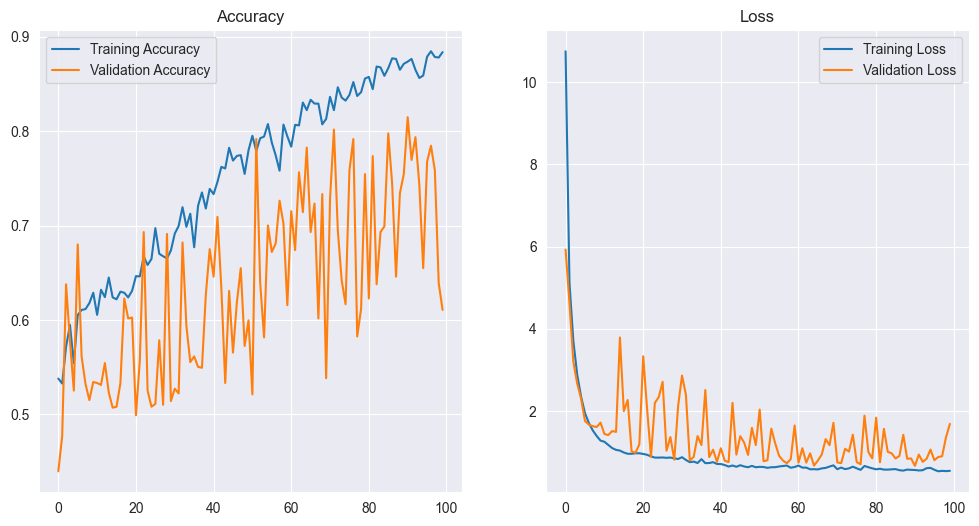

In [70]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

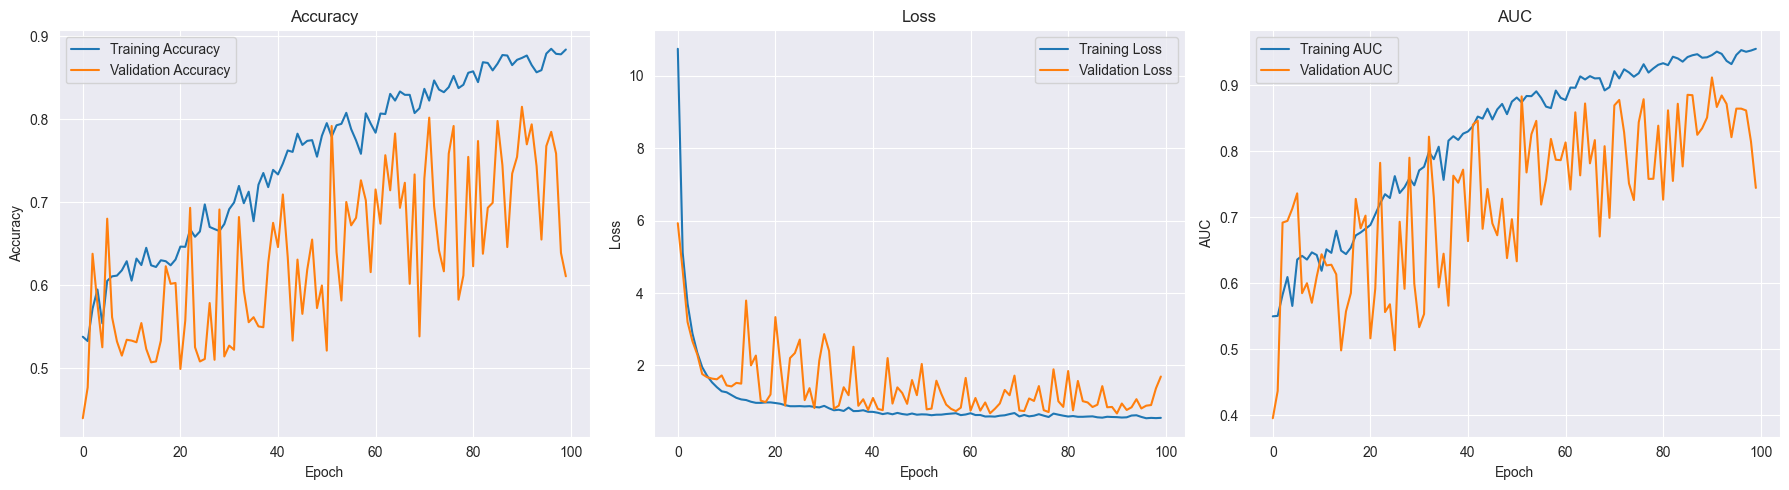

In [76]:
# Plot accuracy, loss, and AUC curves
plt.figure(figsize=(18, 5))

# 1. Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 2. Loss plot
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 3. AUC plot
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


In [72]:
# Train the model
history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
55/55 [==============================] - 15s 276ms/step - loss: 0.5989 - accuracy: 0.8749 - auc: 0.9444 - val_loss: 1.4670 - val_accuracy: 0.6932 - val_auc: 0.8009
Epoch 2/100
55/55 [==============================] - 16s 287ms/step - loss: 0.5703 - accuracy: 0.8839 - auc: 0.9544 - val_loss: 1.0592 - val_accuracy: 0.7827 - val_auc: 0.8636
Epoch 3/100
55/55 [==============================] - 15s 269ms/step - loss: 0.5744 - accuracy: 0.8847 - auc: 0.9554 - val_loss: 1.1244 - val_accuracy: 0.6791 - val_auc: 0.7827
Epoch 4/100
55/55 [==============================] - 27s 486ms/step - loss: 0.7495 - accuracy: 0.8102 - auc: 0.8965 - val_loss: 1.2238 - val_accuracy: 0.6479 - val_auc: 0.8429
Epoch 5/100
55/55 [==============================] - 16s 291ms/step - loss: 0.6212 - accuracy: 0.8703 - auc: 0.9417 - val_loss: 1.0144 - val_accuracy: 0.7284 - val_auc: 0.8347
Epoch 6/100
55/55 [==============================] - 16s 286ms/step - loss: 0.6026 - accuracy: 0.8744 - auc: 0.9462 - va

In [79]:
#Load saved model
from tensorflow.keras.models import load_model
model = load_model('oralcancer.keras')

In [80]:
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

16/16 [==============================] - 1s 31ms/step - loss: 0.6565 - accuracy: 0.8408 - auc: 0.9170
Test Loss: 0.6564833521842957
Test Accuracy: 0.8408163189888
Test AUC: 0.9169957637786865


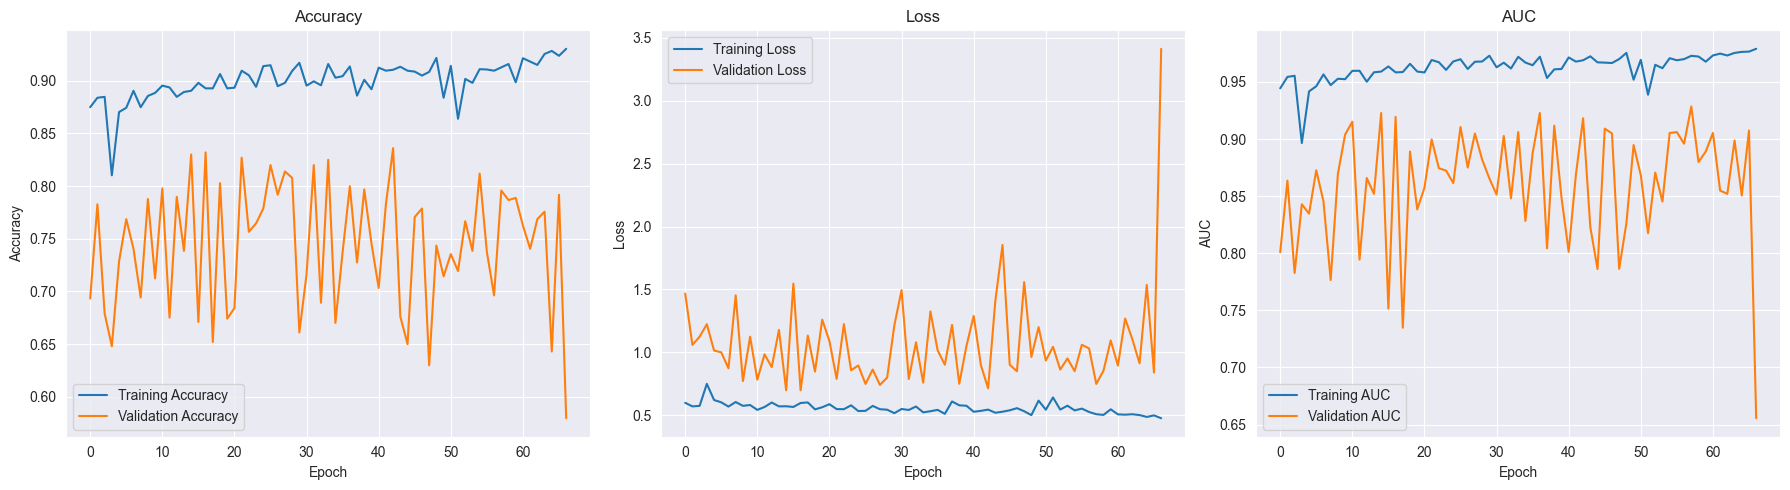

In [78]:
# Plot accuracy, loss, and AUC curves
plt.figure(figsize=(18, 5))

# 1. Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 2. Loss plot
plt.subplot(1, 3, 2)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 3. AUC plot
plt.subplot(1, 3, 3)
plt.plot(history1.history['auc'], label='Training AUC')
plt.plot(history1.history['val_auc'], label='Validation AUC')
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


## Model Evaluation

16/16 [==============================] - 0s 28ms/step


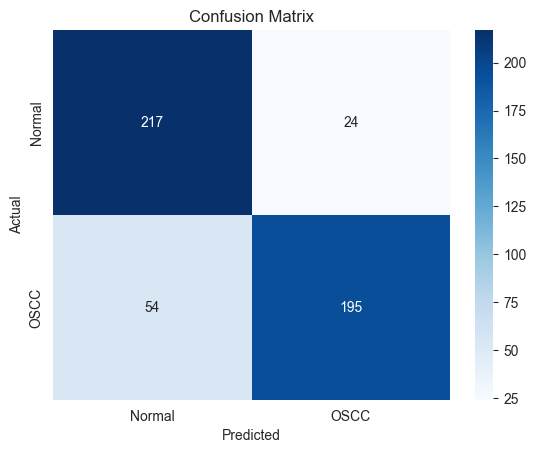

In [82]:
# Get predicted probabilities
y_pred_probs = model.predict(X_test)

# Convert to binary labels (0 or 1) using 0.5 threshold
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# True labels are already 0 or 1, no need for argmax
y_true = y_test  # Assuming y_test is 1D and not one-hot

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
class_names = ['Normal', 'OSCC']

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [83]:
tn, fp, fn, tp = cm.ravel()
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
specificity = tn / (tn + fp)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"True Positive: {tp}")
print(f"True Negative: {tn}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")

Accuracy: 0.8408
Precision: 0.8904
Recall (Sensitivity): 0.7831
Specificity: 0.9004
F1 Score: 0.8333
True Positive: 195
True Negative: 217
False Positive: 24
False Negative: 54


## Using recall as metrics

In [85]:
model = Sequential([
    # Convolutional Block 1
    Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(rate= 0.3, seed= 123),

    # Convolutional Block 2
    Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(rate= 0.3, seed= 123),

    # MaxPooling (Final Pooling Layer)
    MaxPooling2D(pool_size=2, strides=2),
    # Flatten the output for Dense Layers
    Flatten(),

    # Dense Layers
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')

])

model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.01),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')
    ]
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_10 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_11 (Ba  (None, 64, 64, 64)       

In [86]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('oralcancern.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/200
55/55 [==============================] - 18s 300ms/step - loss: 10.3652 - accuracy: 0.5523 - auc: 0.5677 - recall: 0.5626 - precision: 0.5588 - val_loss: 5.8048 - val_accuracy: 0.4940 - val_auc: 0.6208 - val_recall: 0.0020 - val_precision: 1.0000
Epoch 2/200
55/55 [==============================] - 33s 604ms/step - loss: 4.9631 - accuracy: 0.5661 - auc: 0.5598 - recall: 0.2628 - precision: 0.6916 - val_loss: 5.0175 - val_accuracy: 0.5201 - val_auc: 0.4426 - val_recall: 0.0714 - val_precision: 0.8000
Epoch 3/200
55/55 [==============================] - 15s 265ms/step - loss: 3.6285 - accuracy: 0.5820 - auc: 0.5985 - recall: 0.3060 - precision: 0.7033 - val_loss: 3.6263 - val_accuracy: 0.6187 - val_auc: 0.6701 - val_recall: 0.4464 - val_precision: 0.6923
Epoch 4/200
55/55 [==============================] - 17s 309ms/step - loss: 2.8076 - accuracy: 0.6089 - auc: 0.6112 - recall: 0.3430 - precision: 0.7519 - val_loss: 3.1839 - val_accuracy: 0.6127 - val_auc: 0.6686 - val_recall

In [87]:
#Load saved model
from tensorflow.keras.models import load_model
model = load_model('oralcancern.keras')

In [88]:
# Evaluate the model and get all metrics as a dictionary
results = model.evaluate(X_test, y_test, return_dict=True)

# Print all tracked metrics
print(f"Test Loss: {results['loss']:.4f}")
print(f"Test Accuracy: {results['accuracy']:.4f}")
print(f"Test AUC: {results['auc']:.4f}")
print(f"Test Recall (Sensitivity): {results['recall']:.4f}")
print(f"Test Precision: {results['precision']:.4f}")

16/16 [==============================] - 1s 32ms/step - loss: 0.5177 - accuracy: 0.8673 - auc: 0.9401 - recall: 0.8554 - precision: 0.8802
Test Loss: 0.5177
Test Accuracy: 0.8673
Test AUC: 0.9401
Test Recall (Sensitivity): 0.8554
Test Precision: 0.8802


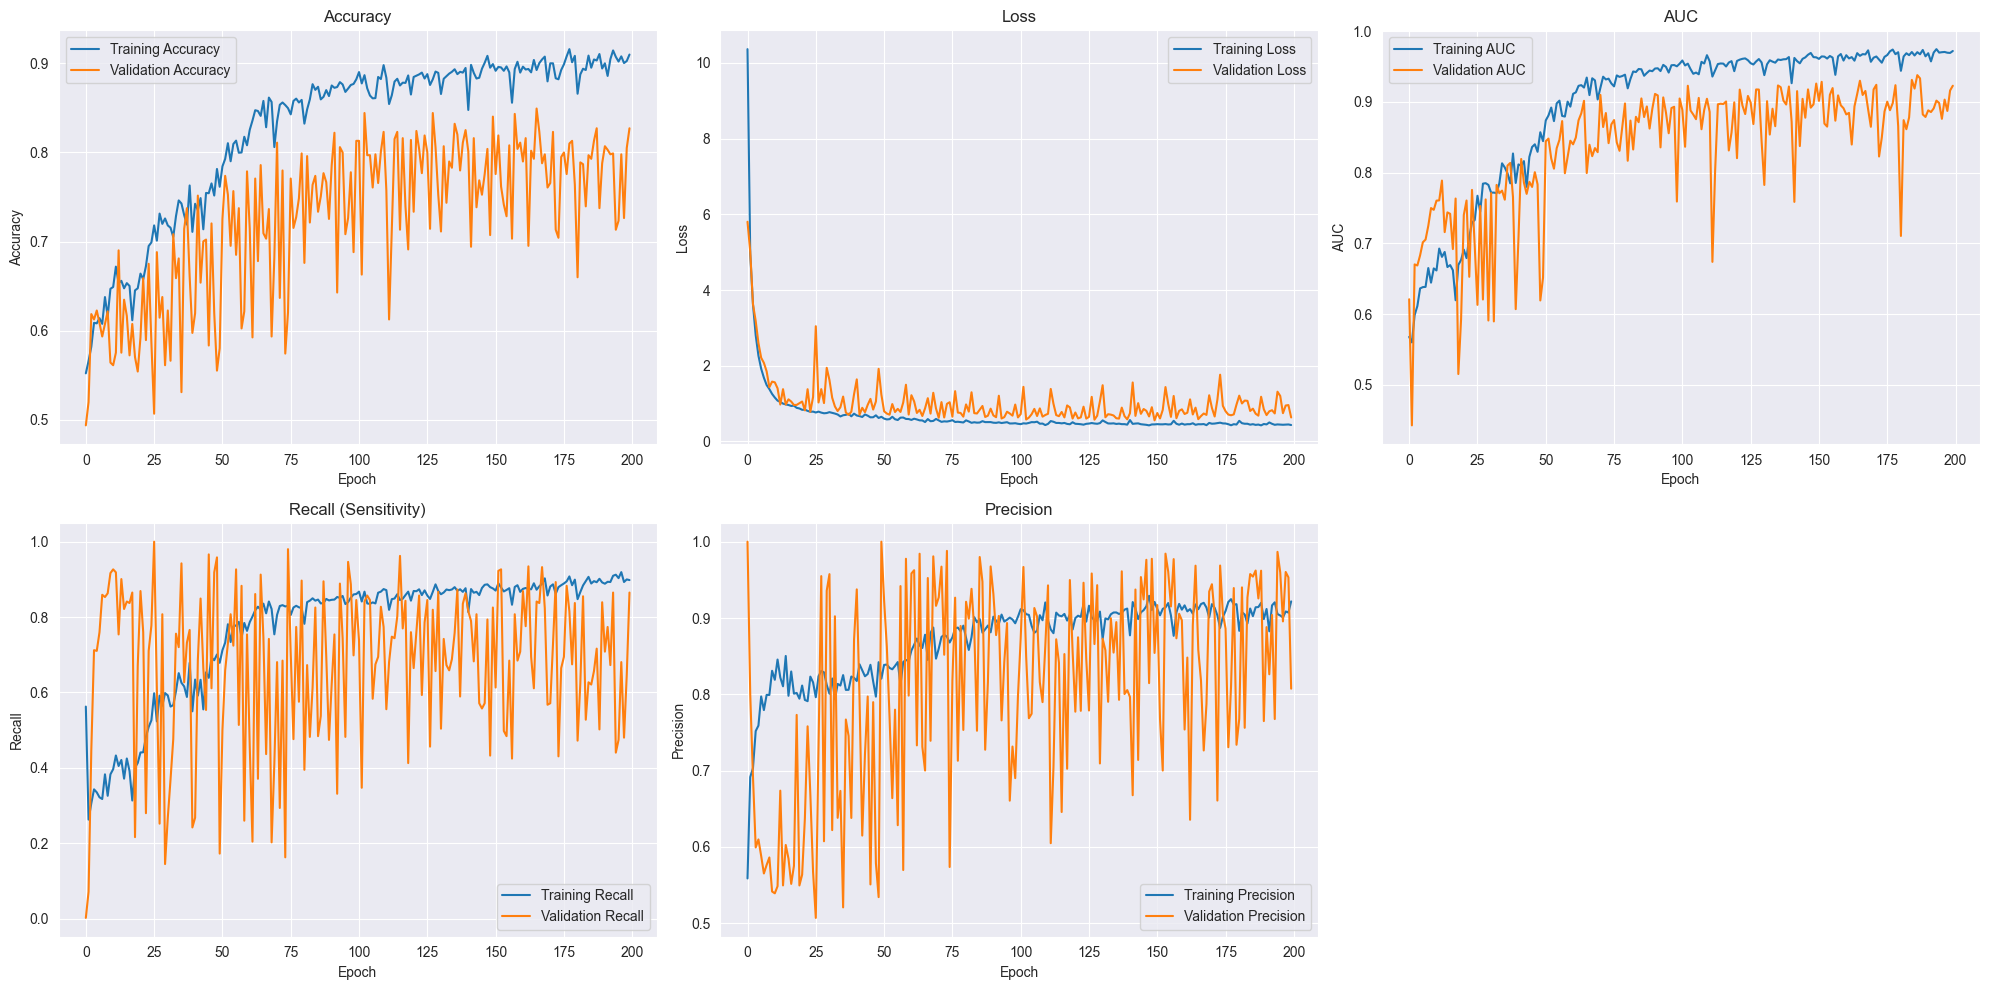

In [89]:
import matplotlib.pyplot as plt

# Plot accuracy, loss, AUC, recall, and precision curves
plt.figure(figsize=(20, 10))

# 1. Accuracy plot
plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 2. Loss plot
plt.subplot(2, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 3. AUC plot
plt.subplot(2, 3, 3)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

# 4. Recall plot
plt.subplot(2, 3, 4)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall (Sensitivity)')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# 5. Precision plot
plt.subplot(2, 3, 5)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()


16/16 [==============================] - 1s 30ms/step


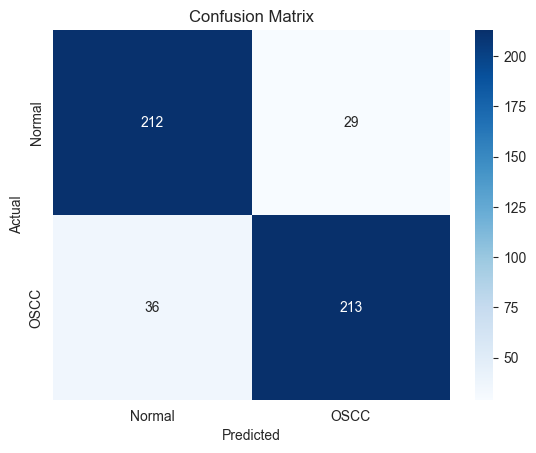

In [90]:
# Get predicted probabilities
y_pred_probs = model.predict(X_test)

# Convert to binary labels (0 or 1) using 0.5 threshold
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# True labels are already 0 or 1, no need for argmax
y_true = y_test  # Assuming y_test is 1D and not one-hot

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
class_names = ['Normal', 'OSCC']

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [92]:
tn, fp, fn, tp = cm.ravel()
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
specificity = tn / (tn + fp)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"True Positive: {tp}")
print(f"True Negative: {tn}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")

Accuracy: 0.8673
Precision: 0.8802
Recall (Sensitivity): 0.8554
Specificity: 0.8797
F1 Score: 0.8676
True Positive: 213
True Negative: 212
False Positive: 29
False Negative: 36


In [93]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. Get prediction probabilities
y_probs = model.predict(X_test).flatten()  # Output probabilities
y_true = y_test                            # Ground truth labels (0 or 1)

# 2. Set up thresholds and track metrics
thresholds = np.arange(0.1, 0.91, 0.01)
best_threshold = 0.5
best_f1 = 0

f1_scores = []
recalls = []
precisions = []

for thresh in thresholds:
    y_pred = (y_probs > thresh).astype(int)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

# 3. Print best threshold and its metrics
print(f"🔍 Best Threshold: {best_threshold:.2f}")
print(f"Precision: {precision_score(y_true, (y_probs > best_threshold).astype(int)):.4f}")
print(f"Recall:    {recall_score(y_true, (y_probs > best_threshold).astype(int)):.4f}")
print(f"F1 Score:  {f1_score(y_true, (y_probs > best_threshold).astype(int)):.4f}")


16/16 [==============================] - 1s 33ms/step
🔍 Best Threshold: 0.58
Precision: 0.9052
Recall:    0.8434
F1 Score:  0.8732


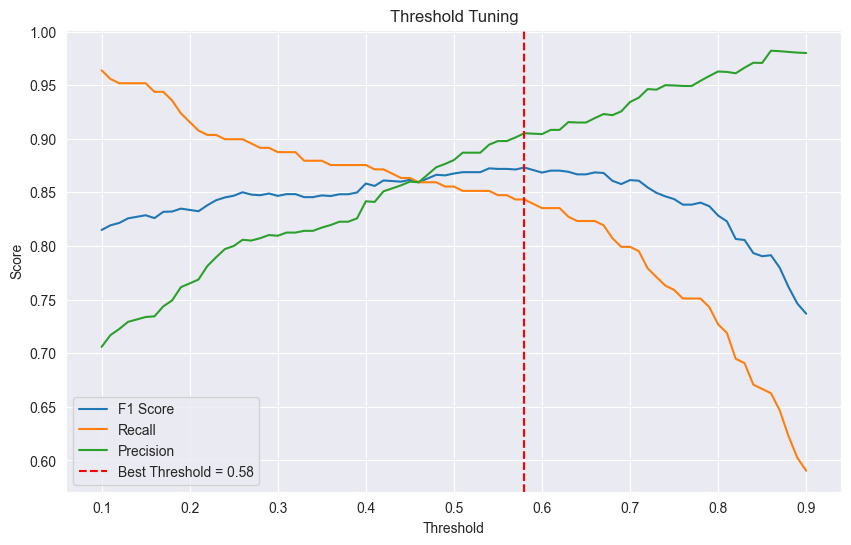

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, precisions, label='Precision')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.title("Threshold Tuning")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


16/16 [==============================] - 1s 32ms/step


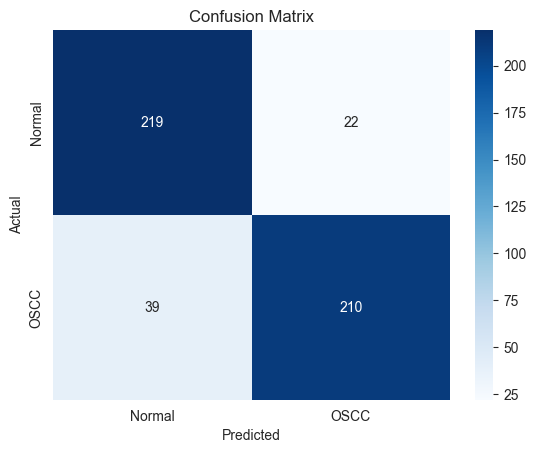

In [96]:
# Get predicted probabilities
y_pred_probs = model.predict(X_test)

# Convert to binary labels (0 or 1) using best threshold
y_pred = (y_pred_probs > best_threshold).astype(int).flatten()

# True labels are already 0 or 1, no need for argmax
y_true = y_test  # Assuming y_test is 1D and not one-hot

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
class_names = ['Normal', 'OSCC']

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


16/16 [==============================] - 1s 32ms/step


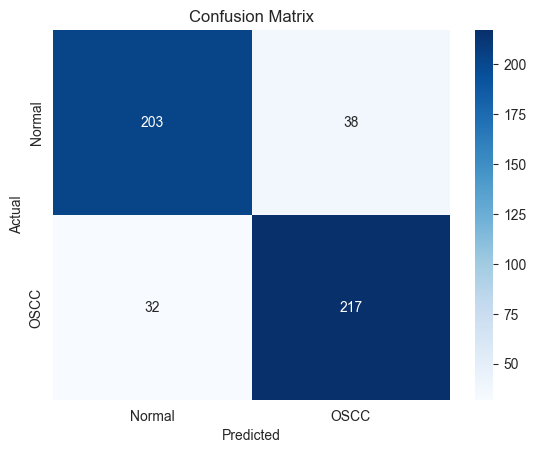

In [102]:
# Get predicted probabilities
y_pred_probs = model.predict(X_test)

# Convert to binary labels (0 or 1) using best threshold
y_pred = (y_pred_probs > 0.42).astype(int).flatten()

# True labels are already 0 or 1, no need for argmax
y_true = y_test  # Assuming y_test is 1D and not one-hot

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
class_names = ['Normal', 'OSCC']

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [103]:
best_threshold = 0.42
print(f"Precision: {precision_score(y_true, (y_probs > best_threshold).astype(int)):.4f}")
print(f"Recall:    {recall_score(y_true, (y_probs > best_threshold).astype(int)):.4f}")
print(f"F1 Score:  {f1_score(y_true, (y_probs > best_threshold).astype(int)):.4f}")

Precision: 0.8510
Recall:    0.8715
F1 Score:  0.8611


## try all in one other solutions


🚀 Training ResNet50...
Epoch 1/200
55/55 [==============================] - 79s 1s/step - loss: 7.4908 - accuracy: 0.5150 - auc: 0.5214 - recall: 0.5142 - val_loss: 7.3679 - val_accuracy: 0.4930 - val_auc: 0.5013 - val_recall: 0.0000e+00 - lr: 1.0000e-05
Epoch 2/200
55/55 [==============================] - 56s 1s/step - loss: 7.3512 - accuracy: 0.5485 - auc: 0.5813 - recall: 0.5694 - val_loss: 7.3216 - val_accuracy: 0.4859 - val_auc: 0.4505 - val_recall: 0.0139 - lr: 1.0000e-05
Epoch 3/200
55/55 [==============================] - 56s 1s/step - loss: 7.2863 - accuracy: 0.5630 - auc: 0.5973 - recall: 0.5666 - val_loss: 7.2809 - val_accuracy: 0.4940 - val_auc: 0.4677 - val_recall: 0.0813 - lr: 1.0000e-05
Epoch 4/200
55/55 [==============================] - 57s 1s/step - loss: 7.2115 - accuracy: 0.5869 - auc: 0.6329 - recall: 0.5870 - val_loss: 7.2176 - val_accuracy: 0.5050 - val_auc: 0.5067 - val_recall: 0.5853 - lr: 1.0000e-05
Epoch 5/200
55/55 [==============================] - 59s 1s/

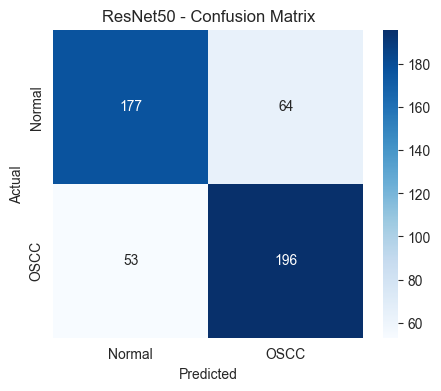

✅ ResNet50 Results:
Loss: 3.3442 | Accuracy: 0.7612 | AUC: 0.8169 | Recall: 0.7871

🚀 Training EfficientNetB0...
16705208/16705208 [==============================] - 3s 0us/step
Epoch 1/200
55/55 [==============================] - 40s 526ms/step - loss: 7.4414 - accuracy: 0.5130 - auc: 0.5102 - recall: 0.5034 - val_loss: 7.2686 - val_accuracy: 0.4930 - val_auc: 0.5037 - val_recall: 0.0000e+00 - lr: 1.0000e-05
Epoch 2/200
55/55 [==============================] - 26s 480ms/step - loss: 7.3292 - accuracy: 0.5393 - auc: 0.5538 - recall: 0.5512 - val_loss: 7.2327 - val_accuracy: 0.4930 - val_auc: 0.5428 - val_recall: 0.0000e+00 - lr: 1.0000e-05
Epoch 3/200
55/55 [==============================] - 26s 478ms/step - loss: 7.2789 - accuracy: 0.5300 - auc: 0.5525 - recall: 0.5563 - val_loss: 7.1994 - val_accuracy: 0.5070 - val_auc: 0.5050 - val_recall: 1.0000 - lr: 1.0000e-05
Epoch 4/200
55/55 [==============================] - 63s 1s/step - loss: 7.2231 - accuracy: 0.5618 - auc: 0.5765 - recall

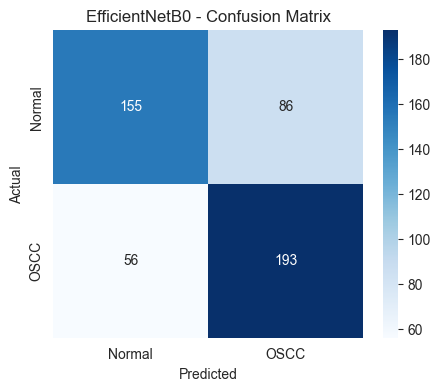

✅ EfficientNetB0 Results:
Loss: 2.3166 | Accuracy: 0.7102 | AUC: 0.7897 | Recall: 0.7751

🚀 Training MobileNetV2...
9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/200
55/55 [==============================] - 26s 384ms/step - loss: 7.4470 - accuracy: 0.5326 - auc: 0.5409 - recall: 0.5569 - val_loss: 7.2596 - val_accuracy: 0.5674 - val_auc: 0.6058 - val_recall: 0.4980 - lr: 1.0000e-05
Epoch 2/200
55/55 [==============================] - 13s 230ms/step - loss: 7.3284 - accuracy: 0.5765 - auc: 0.6128 - recall: 0.5984 - val_loss: 7.1831 - val_accuracy: 0.6237 - val_auc: 0.6751 - val_recall: 0.5496 - lr: 1.0000e-05
Epoch 3/200
55/55 [==============================] - 13s 228ms/step - loss: 7.2298 - accuracy: 0.6288 - auc: 0.6765 - recall: 0.6468 - val_loss: 7.1236 - val_accuracy: 0.6539 - val_auc: 0.7208 - val_recall: 0.5536 - lr: 1.0000e-05
Epoch 4/200
55/55 [==============================] - 13s 229ms/step - loss: 7.1214 - accuracy: 0.6730 - auc: 0.7367 - recall: 0.

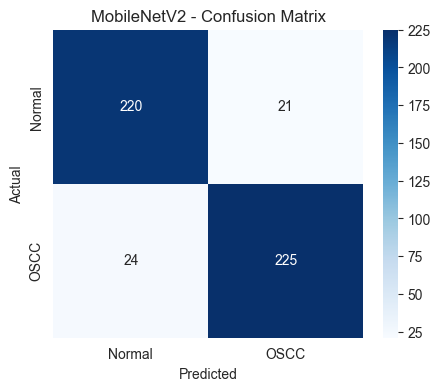

✅ MobileNetV2 Results:
Loss: 0.9833 | Accuracy: 0.9082 | AUC: 0.9537 | Recall: 0.9036


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers.experimental import AdamW
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Model Builder ---
def build_transfer_model_binary(base_model_fn, input_shape=(128, 128, 3)):
    base_model = base_model_fn(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True
    for layer in base_model.layers[:100]:  # Freeze the first 100 layers
        layer.trainable = False

    model = Sequential([
        base_model,
        MaxPooling2D(pool_size=2, strides=2),
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.4),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.4),
        Dense(1, activation='sigmoid')  # Binary output
    ])

    model.compile(
        optimizer=AdamW(learning_rate=1e-5, weight_decay=0.01),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Recall(name='recall')]
    )

    return model

# --- Callbacks ---
def get_callbacks(model_name):
    return [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
        ModelCheckpoint(f'{model_name}_best.keras', save_best_only=True, monitor='val_loss')
    ]

# --- Evaluation & Visualization ---
def evaluate_model(model, X_test, y_test, model_name):
    y_probs = model.predict(X_test).flatten()
    y_pred = (y_probs > 0.5).astype(int)
    y_true = y_test

    # Metrics
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'OSCC']))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'OSCC'], yticklabels=['Normal', 'OSCC'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    loss, acc, auc, recall = model.evaluate(X_test, y_test, verbose=0)
    print(f"✅ {model_name} Results:")
    print(f"Loss: {loss:.4f} | Accuracy: {acc:.4f} | AUC: {auc:.4f} | Recall: {recall:.4f}")

# --- Training Wrapper ---
def train_and_evaluate_model(model_name, base_model_fn):
    print(f"\n🚀 Training {model_name}...")

    model = build_transfer_model_binary(base_model_fn)
    callbacks = get_callbacks(model_name)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=64,
        callbacks=callbacks,
        verbose=1
    )

    evaluate_model(model, X_test, y_test, model_name)
    return model, history

# --- Run All Models ---
model_fns = {
    "ResNet50": ResNet50,
    "EfficientNetB0": EfficientNetB0,
    "MobileNetV2": MobileNetV2
}

histories = {}

for name, fn in model_fns.items():
    model, history = train_and_evaluate_model(name, fn)
    histories[name] = history

In [15]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model

model = load_model('MobileNetV2_best.keras')

# 1. Get prediction probabilities
y_probs = model.predict(X_test).flatten()  # Output probabilities
y_true = y_test                            # Ground truth labels (0 or 1)

# 2. Set up thresholds and track metrics
thresholds = np.arange(0.1, 0.91, 0.01)
best_threshold_mn = 0.5
best_f1 = 0

f1_scores = []
recalls = []
precisions = []

for thresh in thresholds:
    y_pred = (y_probs > thresh).astype(int)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold_mn = thresh

# 3. Print best threshold and its metrics
print(f"🔍 Best Threshold: {best_threshold_mn:.2f}")
print(f"Precision: {precision_score(y_true, (y_probs > best_threshold_mn).astype(int)):.4f}")
print(f"Recall:    {recall_score(y_true, (y_probs > best_threshold_mn).astype(int)):.4f}")
print(f"F1 Score:  {f1_score(y_true, (y_probs > best_threshold_mn).astype(int)):.4f}")


16/16 [==============================] - 2s 74ms/step
🔍 Best Threshold: 0.52
Precision: 0.9184
Recall:    0.9036
F1 Score:  0.9109


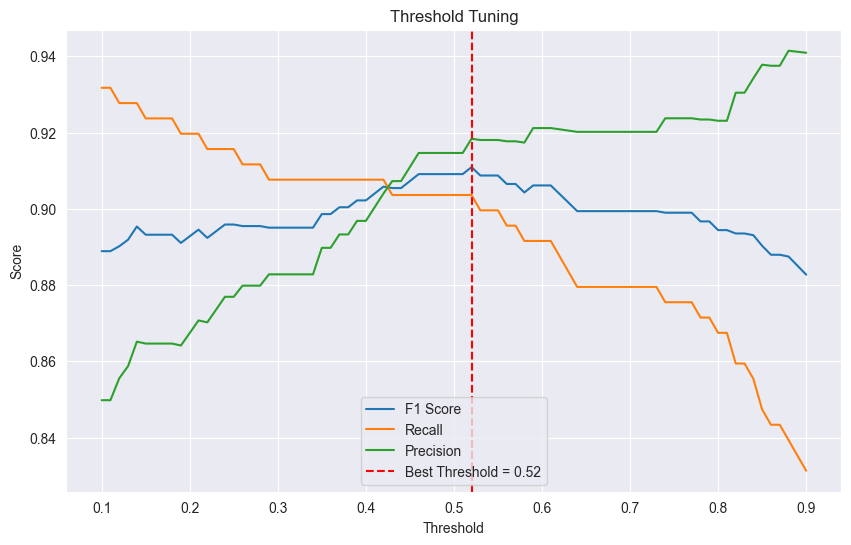

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, precisions, label='Precision')
plt.axvline(best_threshold_mn, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.title("Threshold Tuning")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


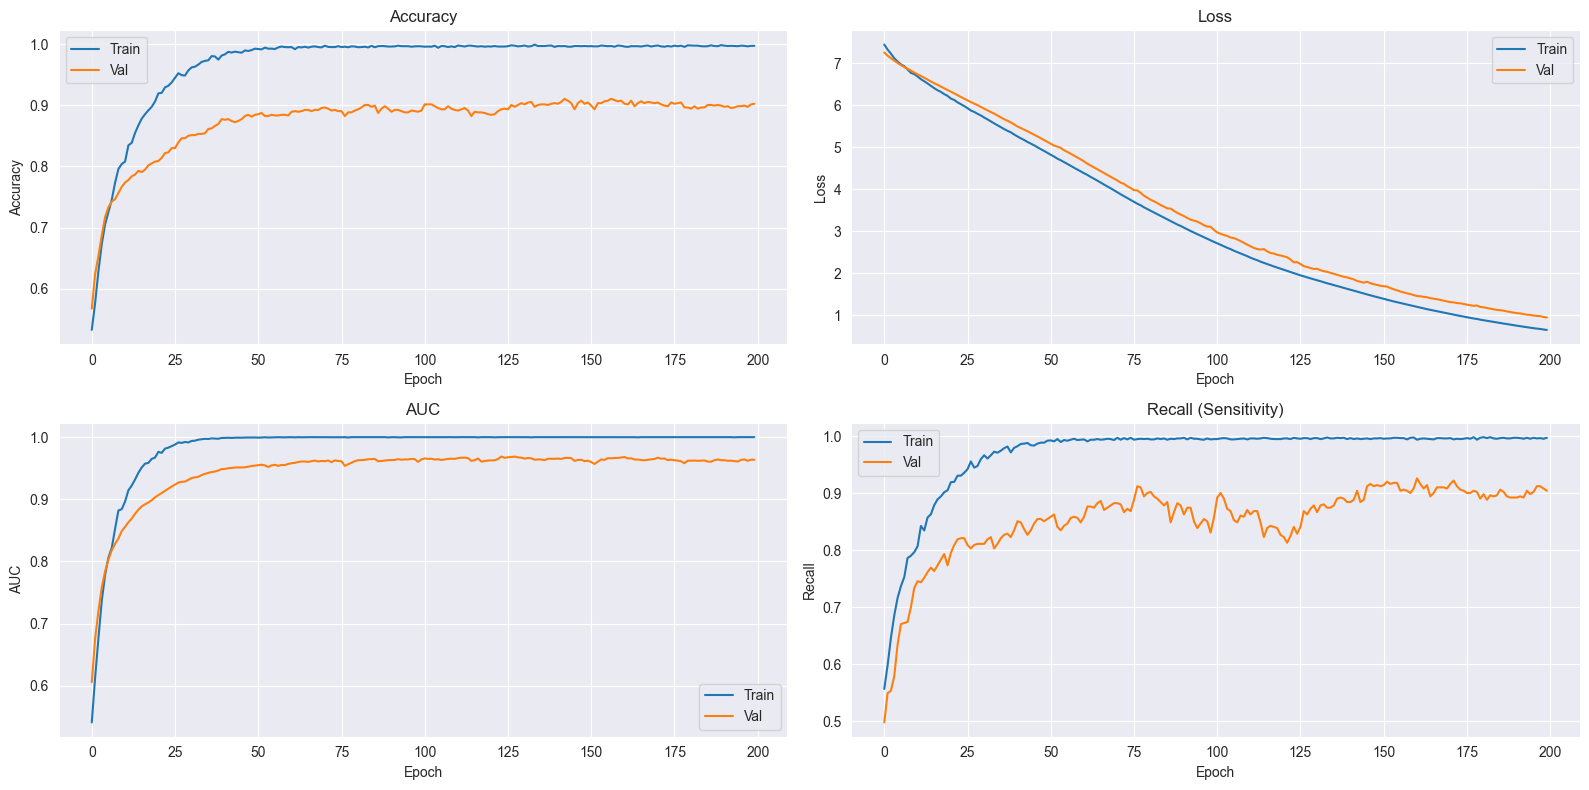

In [17]:
import matplotlib.pyplot as plt

def plot_training_curves_partial(history):
    plt.figure(figsize=(16, 8))

    # 1. Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 2. Loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 3. AUC
    plt.subplot(2, 2, 3)
    plt.plot(history.history['auc'], label='Train')
    plt.plot(history.history['val_auc'], label='Val')
    plt.title('AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    # 4. Recall
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Train')
    plt.plot(history.history['val_recall'], label='Val')
    plt.title('Recall (Sensitivity)')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_curves_partial(histories["MobileNetV2"])

16/16 [==============================] - 1s 71ms/step


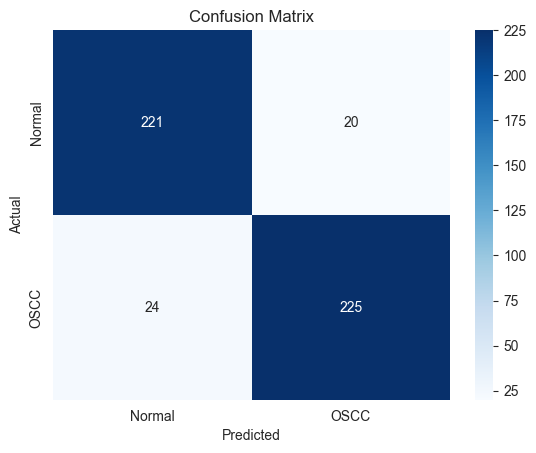

In [18]:
# Get predicted probabilities
y_pred_probs = model.predict(X_test)

# Convert to binary labels (0 or 1) using best threshold
y_pred = (y_pred_probs > 0.52).astype(int).flatten()

# True labels are already 0 or 1, no need for argmax
y_true = y_test  # Assuming y_test is 1D and not one-hot

cm = confusion_matrix(y_true, y_pred)
class_names = ['Normal', 'OSCC']

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [19]:
tn, fp, fn, tp = cm.ravel()
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
specificity = tn / (tn + fp)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"True Positive: {tp}")
print(f"True Negative: {tn}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")

Accuracy: 0.9102
Precision: 0.9184
Recall (Sensitivity): 0.9036
Specificity: 0.9170
F1 Score: 0.9109
True Positive: 225
True Negative: 221
False Positive: 20
False Negative: 24


## ResNet

Use of an alternate model for performance comparison

In [35]:
# Load the ResNet50 model pre-trained on ImageNet
# Exclude the top fully connected layers using include_top=False
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the pre-trained layers to retain ImageNet weights
base_model.trainable = False

# Create a new model on top of the ResNet50 base
model = Sequential([
    base_model,
    MaxPooling2D(pool_size=2, strides=2),  # Flatten the feature maps to a vector
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Add a dense layer with 256 units
    Dropout(0.5),  # Dropout for regularization
    Dense(2, activation='softmax')  # Output layer for binary classification
])

# Compile the model
model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.01),
    loss=CategoricalCrossentropy(),      # Use categorical crossentropy for binary classification
    metrics=['accuracy']                 # Track accuracy during training
)

# Display the model summary
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 2, 2, 2048)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_14 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 2)                 514       
                                                      

In [36]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)

Epoch 1/10
55/55 [==============================] - 37s 628ms/step - loss: 1.5986 - accuracy: 0.5092 - val_loss: 0.8722 - val_accuracy: 0.5070
Epoch 2/10
55/55 [==============================] - 35s 634ms/step - loss: 0.7602 - accuracy: 0.5159 - val_loss: 0.7348 - val_accuracy: 0.5241
Epoch 3/10
55/55 [==============================] - 34s 614ms/step - loss: 0.7320 - accuracy: 0.5113 - val_loss: 0.7244 - val_accuracy: 0.5342
Epoch 4/10
55/55 [==============================] - 36s 657ms/step - loss: 0.7227 - accuracy: 0.5090 - val_loss: 0.7193 - val_accuracy: 0.4930
Epoch 5/10
55/55 [==============================] - 34s 622ms/step - loss: 0.7174 - accuracy: 0.5061 - val_loss: 0.7138 - val_accuracy: 0.5070
Epoch 6/10
55/55 [==============================] - 33s 599ms/step - loss: 0.7128 - accuracy: 0.5084 - val_loss: 0.7100 - val_accuracy: 0.5070
Epoch 7/10
55/55 [==============================] - 32s 589ms/step - loss: 0.7087 - accuracy: 0.5136 - val_loss: 0.7075 - val_accuracy: 0.4930

In [37]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

16/16 [==============================] - 4s 225ms/step - loss: 0.7019 - accuracy: 0.5082
Test Loss: 0.7018794417381287
Test Accuracy: 0.5081632733345032


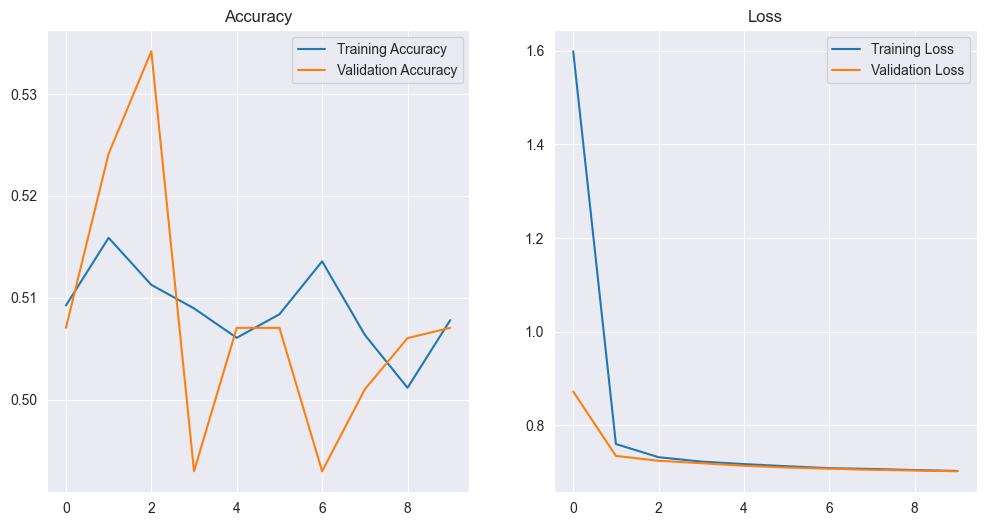

In [38]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet_oralcancer_model.keras', save_best_only=True, monitor='val_loss')

history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
55/55 [==============================] - 32s 591ms/step - loss: 0.7015 - accuracy: 0.5075 - val_loss: 0.7018 - val_accuracy: 0.5070
Epoch 2/100
55/55 [==============================] - 32s 583ms/step - loss: 0.7013 - accuracy: 0.5078 - val_loss: 0.6998 - val_accuracy: 0.5070
Epoch 3/100
55/55 [==============================] - 31s 574ms/step - loss: 0.6996 - accuracy: 0.5006 - val_loss: 0.6990 - val_accuracy: 0.5070
Epoch 4/100
55/55 [==============================] - 32s 581ms/step - loss: 0.6992 - accuracy: 0.5078 - val_loss: 0.6986 - val_accuracy: 0.5070
Epoch 5/100
55/55 [==============================] - 32s 577ms/step - loss: 0.6981 - accuracy: 0.5078 - val_loss: 0.6977 - val_accuracy: 0.5070
Epoch 6/100
55/55 [==============================] - 32s 586ms/step - loss: 0.6975 - accuracy: 0.5078 - val_loss: 0.6972 - val_accuracy: 0.5070
Epoch 7/100
55/55 [==============================] - 32s 590ms/step - loss: 0.6970 - accuracy: 0.5084 - val_loss: 0.6967 - val_accuracy:

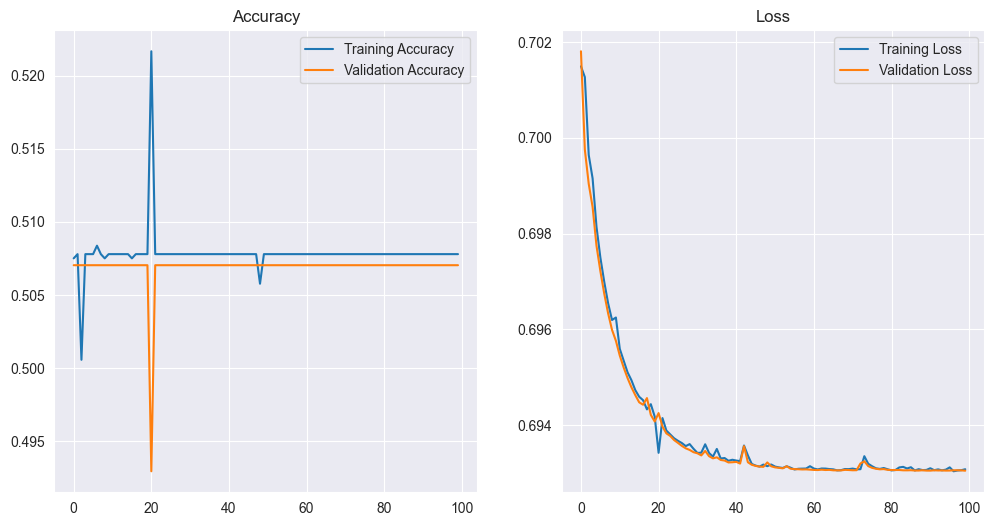

In [40]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [48]:
# Load the ResNet50 model pre-trained on ImageNet
# Exclude the top fully connected layers using include_top=False
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze the first 100 layers
    layer.trainable = False


# Create a new model on top of the ResNet50 base
model = Sequential([
    base_model,
    MaxPooling2D(pool_size=2, strides=2),  # Flatten the feature maps to a vector
    Flatten(),
    Dense(256, activation='relu'),  # Add a dense layer with 256 units
    Dropout(0.3),  # Dropout for regularization
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # Output layer for binary classification
])

# Compile the model
model.compile(
    optimizer=AdamW(learning_rate=0.0001, weight_decay=0.01),
    loss=CategoricalCrossentropy(),      # Use categorical crossentropy for binary classification
    metrics=['accuracy']                 # Track accuracy during training
)

# Display the model summary
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 2, 2, 2048)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_22 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                     

In [49]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet_oralcancer_model1.keras', save_best_only=True, monitor='val_loss')

history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
55/55 [==============================] - 63s 994ms/step - loss: 0.9141 - accuracy: 0.5142 - val_loss: 0.7164 - val_accuracy: 0.4950
Epoch 2/100
55/55 [==============================] - 52s 946ms/step - loss: 0.7367 - accuracy: 0.5376 - val_loss: 0.7143 - val_accuracy: 0.5020
Epoch 3/100
55/55 [==============================] - 52s 940ms/step - loss: 0.6865 - accuracy: 0.5650 - val_loss: 0.7034 - val_accuracy: 0.5000
Epoch 4/100
55/55 [==============================] - 53s 958ms/step - loss: 0.6714 - accuracy: 0.5806 - val_loss: 0.7009 - val_accuracy: 0.4920
Epoch 5/100
55/55 [==============================] - 52s 956ms/step - loss: 0.6621 - accuracy: 0.6072 - val_loss: 0.6674 - val_accuracy: 0.5855
Epoch 6/100
55/55 [==============================] - 50s 919ms/step - loss: 0.6697 - accuracy: 0.5754 - val_loss: 0.6750 - val_accuracy: 0.5352
Epoch 7/100
55/55 [==============================] - 52s 951ms/step - loss: 0.6566 - accuracy: 0.5942 - val_loss: 0.6668 - val_accuracy:

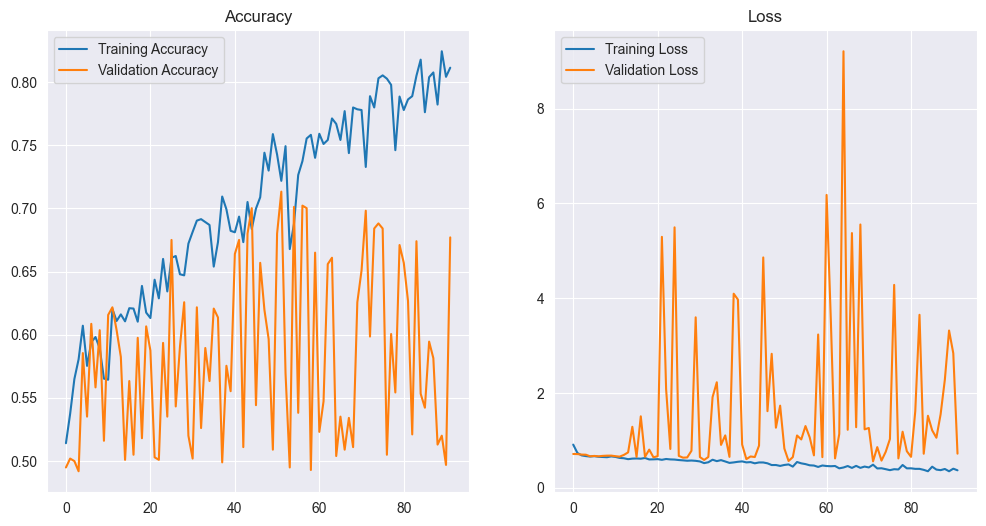

In [50]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [60]:
model = load_model('resnet_oralcancer_model1.keras')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 2, 2, 2048)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_22 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                     

In [61]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

16/16 [==============================] - 5s 245ms/step - loss: 0.6000 - accuracy: 0.7367
Test Loss: 0.5999942421913147
Test Accuracy: 0.7367346882820129


In [54]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet_oralcancer_model1.keras', save_best_only=True, monitor='val_loss')

history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
55/55 [==============================] - 67s 1s/step - loss: 0.4160 - accuracy: 0.7839 - val_loss: 3.6072 - val_accuracy: 0.5664
Epoch 2/100
55/55 [==============================] - 63s 1s/step - loss: 0.4067 - accuracy: 0.7923 - val_loss: 0.6043 - val_accuracy: 0.7203
Epoch 3/100
55/55 [==============================] - 57s 1s/step - loss: 0.4657 - accuracy: 0.7643 - val_loss: 0.6395 - val_accuracy: 0.6087
Epoch 4/100
55/55 [==============================] - 57s 1s/step - loss: 0.4217 - accuracy: 0.7735 - val_loss: 2.3434 - val_accuracy: 0.6016
Epoch 5/100
55/55 [==============================] - 57s 1s/step - loss: 0.3821 - accuracy: 0.7978 - val_loss: 6.0162 - val_accuracy: 0.5080
Epoch 6/100
55/55 [==============================] - 57s 1s/step - loss: 0.3884 - accuracy: 0.8044 - val_loss: 0.7046 - val_accuracy: 0.7193
Epoch 7/100
55/55 [==============================] - 57s 1s/step - loss: 0.3614 - accuracy: 0.8180 - val_loss: 8.2212 - val_accuracy: 0.5302
Epoch 8/100
5

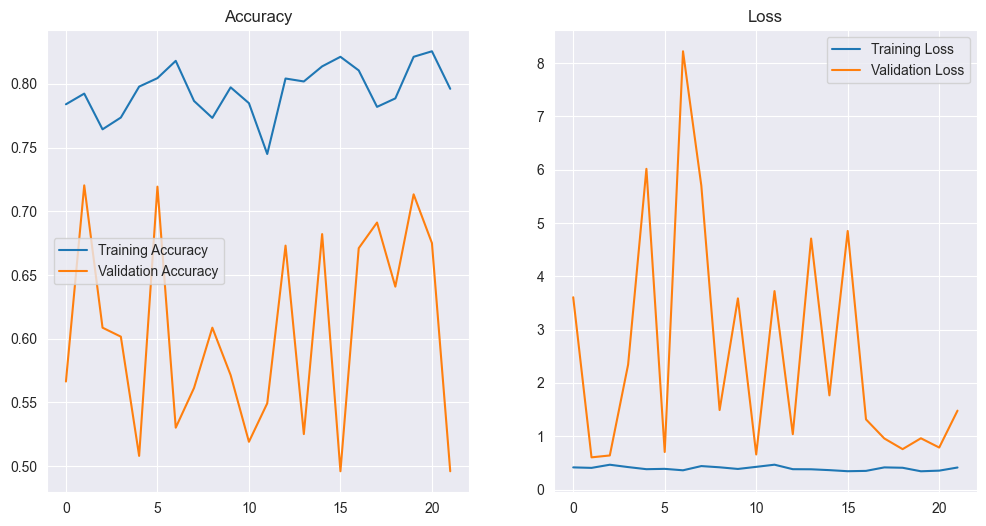

In [55]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [62]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Compile the model with a small learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet_oralcancer_model11.keras', save_best_only=True, monitor='val_loss')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)

# Train the model
history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/100
55/55 [==============================] - 65s 1s/step - loss: 0.3520 - accuracy: 0.8172 - val_loss: 0.8850 - val_accuracy: 0.7022 - lr: 1.0000e-05
Epoch 2/100
55/55 [==============================] - 55s 1s/step - loss: 0.3245 - accuracy: 0.8287 - val_loss: 0.8772 - val_accuracy: 0.7042 - lr: 1.0000e-05
Epoch 3/100
55/55 [==============================] - 56s 1s/step - loss: 0.3029 - accuracy: 0.8382 - val_loss: 0.8125 - val_accuracy: 0.7455 - lr: 1.0000e-05
Epoch 4/100
55/55 [==============================] - 55s 994ms/step - loss: 0.3117 - accuracy: 0.8359 - val_loss: 0.7199 - val_accuracy: 0.6781 - lr: 1.0000e-05
Epoch 5/100
55/55 [==============================] - 53s 961ms/step - loss: 0.3014 - accuracy: 0.8423 - val_loss: 0.7419 - val_accuracy: 0.7012 - lr: 1.0000e-05
Epoch 6/100
55/55 [==============================] - 53s 962ms/step - loss: 0.2852 - accuracy: 0.8469 - val_loss: 0.7846 - val_accuracy: 0.7465 - lr: 1.0000e-05
Epoch 7/100
55/55 [========================

In [64]:
model = load_model('resnet_oralcancer_model11.keras')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 2, 2, 2048)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_22 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                     

In [65]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

16/16 [==============================] - 5s 246ms/step - loss: 0.6925 - accuracy: 0.7000
Test Loss: 0.6924569010734558
Test Accuracy: 0.699999988079071


## New ResNet Model

In [66]:
# Load the ResNet50 model pre-trained on ImageNet
# Exclude the top fully connected layers using include_top=False
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze the first 100 layers
    layer.trainable = False

In [79]:
# Create a new model on top of the ResNet50 base
model = Sequential([
    base_model,
    MaxPooling2D(pool_size=2, strides=2),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),  # Batch Normalization for stability
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  # More neurons and L2 regularization
    Dropout(0.4),  # Increased dropout rate
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(2, activation='softmax')  # Output layer for binary classification
])

# Compile the model
model.compile(
    optimizer=AdamW(learning_rate=0.00001, weight_decay=0.01),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

Epoch 1/10
55/55 [==============================] - 80s 1s/step - loss: 7.4168 - accuracy: 0.5994 - val_loss: 9.2889 - val_accuracy: 0.5070 - lr: 1.0000e-05
Epoch 2/10
55/55 [==============================] - 62s 1s/step - loss: 7.1956 - accuracy: 0.6150 - val_loss: 7.5487 - val_accuracy: 0.5191 - lr: 1.0000e-05
Epoch 3/10
55/55 [==============================] - 60s 1s/step - loss: 7.0527 - accuracy: 0.6514 - val_loss: 7.1450 - val_accuracy: 0.5423 - lr: 1.0000e-05
Epoch 4/10
55/55 [==============================] - 61s 1s/step - loss: 6.9366 - accuracy: 0.6502 - val_loss: 6.9293 - val_accuracy: 0.5795 - lr: 1.0000e-05
Epoch 5/10
55/55 [==============================] - 64s 1s/step - loss: 6.8199 - accuracy: 0.6681 - val_loss: 6.7832 - val_accuracy: 0.6227 - lr: 1.0000e-05
Epoch 6/10
55/55 [==============================] - 67s 1s/step - loss: 6.7198 - accuracy: 0.6719 - val_loss: 6.6852 - val_accuracy: 0.6338 - lr: 1.0000e-05
Epoch 7/10
55/55 [==============================] - 62s 1s

In [83]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('resnet_oralcancer_model11.keras', save_best_only=True, monitor='val_loss')

# Fit the model
history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/100
55/55 [==============================] - 67s 1s/step - loss: 6.1965 - accuracy: 0.6967 - val_loss: 6.5869 - val_accuracy: 0.5352 - lr: 1.0000e-05
Epoch 2/100
55/55 [==============================] - 59s 1s/step - loss: 6.1066 - accuracy: 0.6990 - val_loss: 6.2720 - val_accuracy: 0.5976 - lr: 1.0000e-05
Epoch 3/100
55/55 [==============================] - 59s 1s/step - loss: 6.0074 - accuracy: 0.7111 - val_loss: 6.2739 - val_accuracy: 0.5483 - lr: 1.0000e-05
Epoch 4/100
55/55 [==============================] - 57s 1s/step - loss: 5.9068 - accuracy: 0.7189 - val_loss: 6.4337 - val_accuracy: 0.5070 - lr: 1.0000e-05
Epoch 5/100
55/55 [==============================] - 59s 1s/step - loss: 5.8106 - accuracy: 0.7224 - val_loss: 6.2930 - val_accuracy: 0.5322 - lr: 1.0000e-05
Epoch 6/100
55/55 [==============================] - 66s 1s/step - loss: 5.7177 - accuracy: 0.7354 - val_loss: 6.2625 - val_accuracy: 0.5372 - lr: 1.0000e-05
Epoch 7/100
55/55 [==============================] -

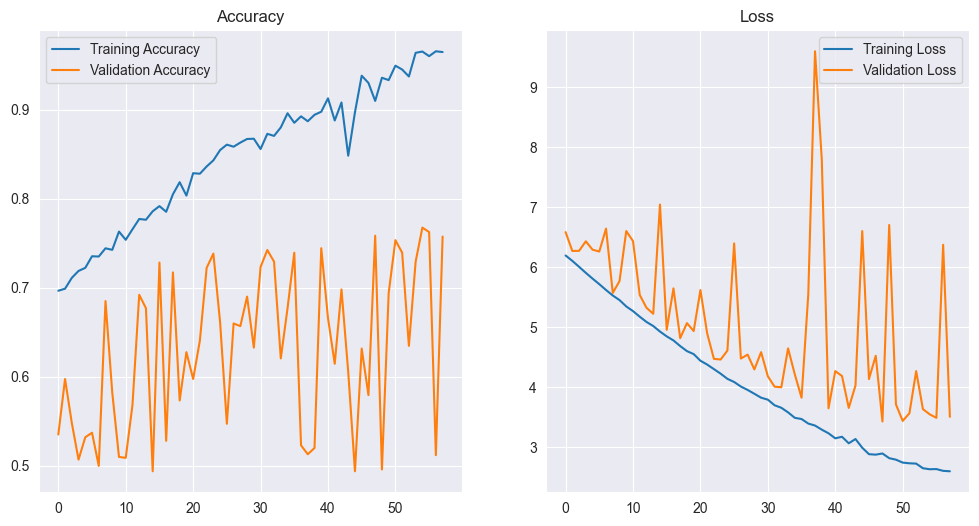

In [84]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [85]:
model = load_model('resnet_oralcancer_model11.keras')
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 2, 2, 2048)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_17 (Ba  (None, 2, 2, 2048)        8192      
 tchNormalization)                                               
                                                                 
 flatten_14 (Flatten)        (None, 8192)              0         
                                                                 
 dense_52 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_48 (Dropout)        (None, 256)             

In [86]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

16/16 [==============================] - 7s 295ms/step - loss: 3.4505 - accuracy: 0.7694
Test Loss: 3.4504847526550293
Test Accuracy: 0.7693877816200256


16/16 [==============================] - 6s 274ms/step


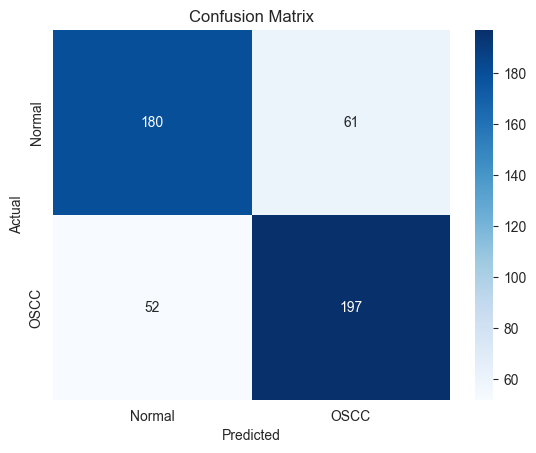

In [87]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()